In [1]:
import ast

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import wandb

In [2]:
api = wandb.Api()

In [4]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_palette('deep')

In [3]:
def get_experiment_data(filters, name, keys):
    runs = api.runs("bartekcupial/sf2_nethack", filters=filters)
    data = []
    for run in runs:
        try:
            # df = run.history(samples=30000, keys=[key])
            df = {key: run.summary[key] for key in keys}
            df = pd.DataFrame(df)
            df["seed"] = run.config["seed"]
            df["train/env_steps"] = run.summary_metrics["train/env_steps"]
            df["name"] = name
            df["exp_tag"] = ast.literal_eval(run.config["exp_tags"])[0]
            
            df = df.assign(ItemList=df[keys[0]].apply(lambda x: [x] if isinstance(x, int) else x)).explode('ItemList')
            del df["ItemList"]
        
            data.append(df)
        except Exception as e:
            pass

    df = pd.concat(data, axis=0).reset_index()
    df.reset_index(drop=True, inplace=True)
    return df

In [4]:
data = []
for exp_tag, name in zip(
    [
        "['2024_01_28_eval_APPO']", 
        "['2024_01_28_eval_APPO-T']", 
        "['2024_01_28_eval_APPO-KS-T']", 
        "['2024_01_28_eval_APPO-BC-T']",
    ],
    [
        "appo", 
        "appo_t", 
        "appo_ks_t", 
        "appo_bc_t",
    ],
):
    df = get_experiment_data({"config.exp_tags": exp_tag}, name, ["reward_p0", "dlvl_p0", "sokobanfillpit_score_p0"])
    data.append(df)
   
data = pd.concat(data, axis=0).reset_index()

In [5]:
data = data[data["train/env_steps"] >= 500_000_000]

In [6]:
method_translator = {
    "appo": "From scratch",
    "appo_t": "Fine-tuning",
    "appo_bc_t": "Fine-tuning + BC",
    "appo_ks_t": "Fine-tuning + KS",
}

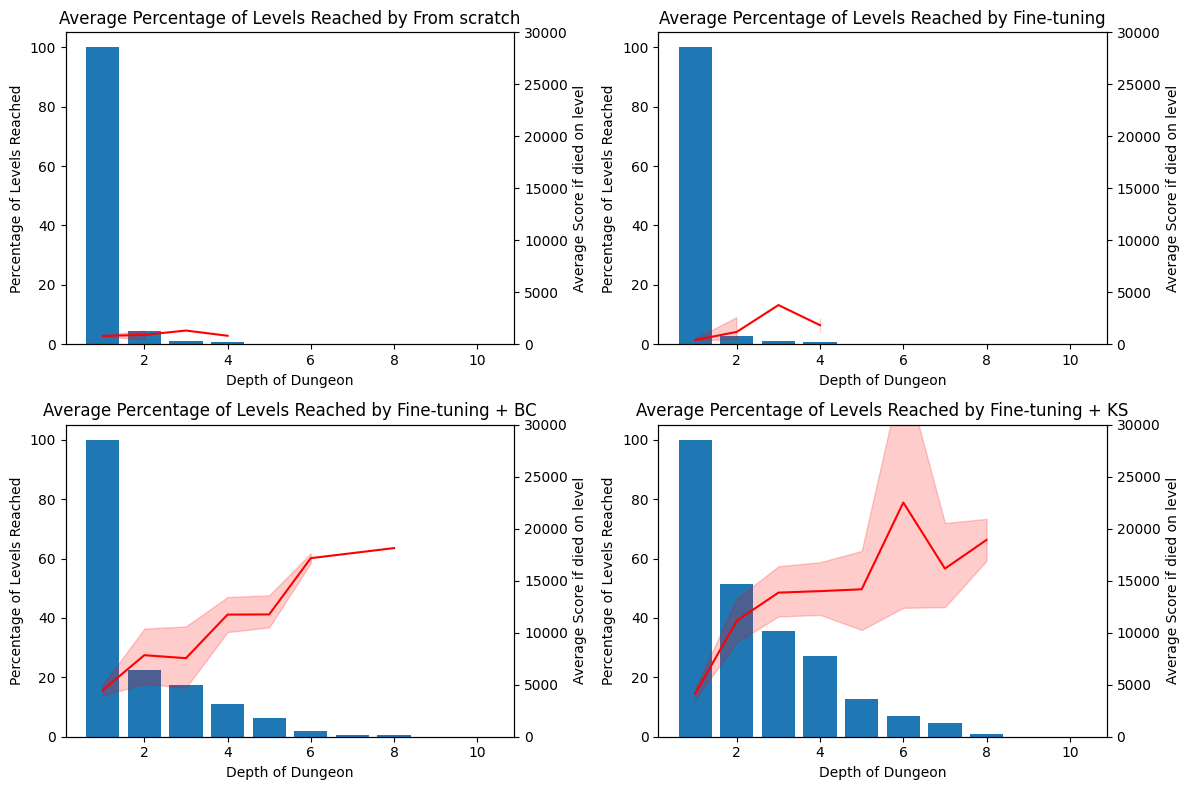

In [20]:
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes = axes.flatten()

for idx, (method, method_name) in enumerate(method_translator.items()):
    ax = axes[idx]
    
    df = data[data["name"] == method]
    df = df[df["dlvl_p0"] <= 10]
    # Example data
    levels_reached = df["dlvl_p0"]
    depths = sorted(set(range(1, 10 + 1)))
    percentage = [sum(1 for level in levels_reached if level >= depth) / len(levels_reached) * 100 for depth in depths]

    depths = depths[:10]
    percentage = percentage[:10]

    ax.bar(depths, percentage)
    ax.set_xlabel("Depth of Dungeon")
    ax.set_ylabel("Percentage of Levels Reached")

    # Create second plot with seaborn
    ax2 = ax.twinx()
    ax2.set_ylim(0, 30000)
    ax2.set_ylabel("Average Score if died on level")
    sns.lineplot(df, x="dlvl_p0", y="reward_p0", color="red", errorbar=('ci', 90), ax=ax2)

    ax.set_title(f"Average Percentage of Levels Reached by {method_name}")
plt.tight_layout()
plt.show()